# Métodos de Aprendizaje no supervisado

In [1]:
import pandas as pd

df = pd.read_excel('../../res/tp4/acath.xlsx', sheet_name='acath')  # 3505 rows

df.head()

,sex,age,cad.dur,choleste,sigdz,tvdlm
0,0,73,132,268.0,1,1.0
1,0,68,85,120.0,1,1.0
2,0,54,45,NaN,1,0.0
3,1,58,86,245.0,0,0.0
4,1,56,7,269.0,0,0.0


In [2]:
negative = df[df.sigdz == 0]
positive = df[df.sigdz == 1]

print(f"Cantidad de filas negativas: {len(negative)}")
print(f"Cantidad de filas positivas: {len(positive)}")

# Se elige un subset de filas para igualar la proporción
positive = positive.sample(n=len(negative))

total = [negative, positive]
df = pd.concat(total)

Cantidad de filas negativas: 1170
Cantidad de filas positivas: 2334


In [3]:
df.head()

,sex,age,cad.dur,choleste,sigdz,tvdlm
3,1,58,86,245.0,0,0.0
4,1,56,7,269.0,0,0.0
11,0,35,44,257.0,0,0.0
12,1,69,10,NaN,0,0.0
20,1,52,30,240.0,0,0.0


In [4]:
import numpy as np

# Sanitize dataset
result_column = 'sigdz'
columns = ['sex', 'age', 'cad.dur', 'choleste', 'tvdlm']
numeric_columns = ['age', 'cad.dur', 'choleste']

# Replace numeric value for `sigdz` with logical value
# df.replace({result_column: {1: 'T', 0: 'F'}}, inplace=True)
# df.replace({'tvdlm': {1: 'T', 0: 'F'}}, inplace=True)
# df.replace({'sex': {1: 'F', 0: 'M'}}, inplace=True)

# Replace NaN occurrences with mean
for column in numeric_columns:
    df.replace({column: {np.nan: int(df[column].mean())}}, inplace=True)

df.head()

,sex,age,cad.dur,choleste,sigdz,tvdlm
3,1,58,86,245.0,0,0.0
4,1,56,7,269.0,0,0.0
11,0,35,44,257.0,0,0.0
12,1,69,10,228.0,0,0.0
20,1,52,30,240.0,0,0.0


## Regresión Logística

In [5]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

def train_model(data, fields, result_var, params=None):
    model = LogisticRegression()
    model.fit(data[fields], data[result_var])
    return model


model = train_model(train, numeric_columns, result_column)
print(f"sklearn Classes: {model.classes_}")
print(f"sklearn Coeficients: {model.coef_}")
print(f"sklearn Intercept b0: {model.intercept_}")

sklearn Classes: [0 1]
sklearn Coeficients: [[ 0.06078631 -0.00062417  0.00637072]]
sklearn Intercept b0: [-4.55231282]


In [7]:
predicted = model.predict(test[numeric_columns])

Población completa


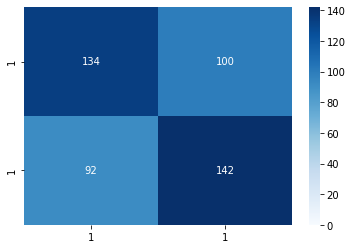

In [8]:
import seaborn as sns

def plot_confusion_matrix(data, result_var, predictions, title=None, ax=None):
    conf_mat = confusion_matrix(data[result_var], predictions)
    count_values = list(map(lambda x: sum(x), conf_mat))

    unique, counts = np.unique(np.array(data[result_var]), return_counts=True)
    count_labels = dict(zip(counts, unique))

    labels = []
    for value in count_values:
        labels.append(count_labels[value])

    if title is not None:
        print(title)

    if ax is None:
        sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, vmin=0)
    else:
        sns.heatmap(conf_mat, ax=ax, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels, vmin=0)

plot_confusion_matrix(test, result_column, predicted, title='Población completa')

In [9]:
print(classification_report(test[result_column], predicted))

              precision    recall  f1-score   support

           0       0.59      0.57      0.58       234
           1       0.59      0.61      0.60       234

    accuracy                           0.59       468
   macro avg       0.59      0.59      0.59       468
weighted avg       0.59      0.59      0.59       468



#### Repetición del experimento usando librería statsmodels

In [95]:
import statsmodels.api as sm

def train_statsmodels_model(data, x1, result_var, params=None):
    model = sm.Logit(data[result_var], x1).fit()
    print(model.summary())
    return model

x1 = sm.add_constant(train[numeric_columns])
statsmodel = train_statsmodels_model(train, x1, result_column)

Optimization terminated successfully.
         Current function value: 0.646798
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  sigdz   No. Observations:                 1872
Model:                          Logit   Df Residuals:                     1868
Method:                           MLE   Df Model:                            3
Date:                Tue, 22 Jun 2021   Pseudo R-squ.:                 0.06687
Time:                        19:43:04   Log-Likelihood:                -1210.8
converged:                       True   LL-Null:                       -1297.6
Covariance Type:            nonrobust   LLR p-value:                 2.200e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.5525      0.403    -11.302      0.000      -5.342      -3.763
age            0.0608      0.

In [96]:
x2 = sm.add_constant(test[numeric_columns])
yhat = statsmodel.predict(x2)
predicted_2 = list(map(round, yhat))
print('Actual values', list(test[result_column].values))
print('statsmodels Predictions :', predicted_2)

Actual values [1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1

statsmodels Población completa


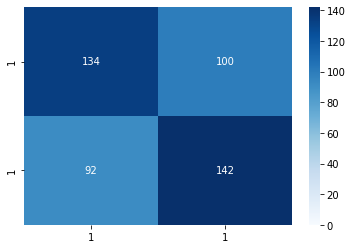

In [97]:
plot_confusion_matrix(test, result_column, predicted_2, title='statsmodels Población completa')

In [10]:
import math

def classify_with_regression(row, model):
    betas = model.params.values
    X = betas[0] + betas[1] * row[0] + betas[2] * row[1] + betas[3] * row[2]
    exp_X = math.exp(X)
    return exp_X / (1 + exp_X)

fila = (60, 199, 2)
proba = classify_with_regression(fila, statsmodel)
print(f"P(X) = {proba}")
print(f"sigdz == {0 if proba < 0.5 else 1}")

P(X) = 0.28533036638708065
sigdz == 0


### Regresión Logística por género

In [118]:
men = df[df.sex == 0]
women = df[df.sex == 1]

train_men, test_men = train_test_split(men, test_size=0.2)
train_women, test_women = train_test_split(women, test_size=0.2)

print(f'Hombres: {len(men)}\nMujeres: {len(women)}')

Hombres: 1463
Mujeres: 877


Optimization terminated successfully.
         Current function value: 0.579819
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  sigdz   No. Observations:                 1170
Model:                          Logit   Df Residuals:                     1166
Method:                           MLE   Df Model:                            3
Date:                Tue, 22 Jun 2021   Pseudo R-squ.:                  0.1189
Time:                        19:57:35   Log-Likelihood:                -678.39
converged:                       True   LL-Null:                       -769.96
Covariance Type:            nonrobust   LLR p-value:                 1.847e-39
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.7411      0.574    -10.002      0.000      -6.866      -4.616
age            0.0804      0.

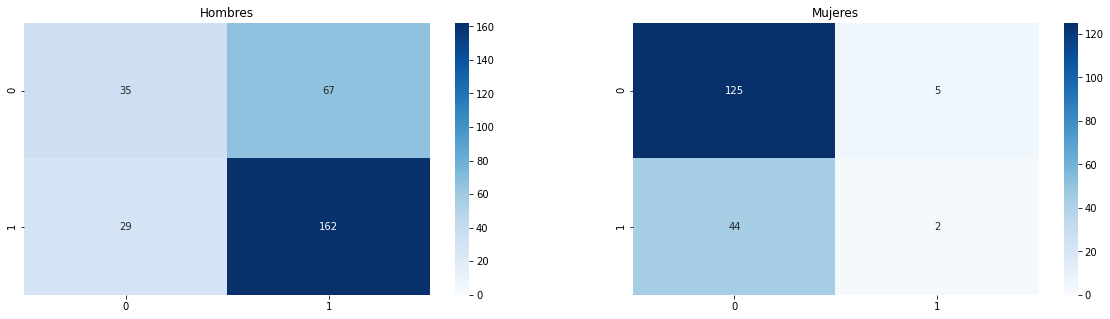

In [119]:
import matplotlib.pyplot as plt

x1_men = sm.add_constant(train_men[numeric_columns])
x1_women = sm.add_constant(train_women[numeric_columns])

model_men_2 = train_statsmodels_model(train_men, x1_men, result_column)
model_women_2 = train_statsmodels_model(train_women, x1_women, result_column)

x2_men = sm.add_constant(test_men[numeric_columns])
x2_women = sm.add_constant(test_women[numeric_columns])

yhat_men = model_men_2.predict(x2_men)
predicted_men_2 = list(map(round, yhat_men))
yhat_women = model_women_2.predict(x2_women)
predicted_women_2 = list(map(round, yhat_women))

tests = [test_men, test_women]
preds = [predicted_men_2, predicted_women_2]
titles = ['Hombres', 'Mujeres']

conf_mat_fig = plt.figure(figsize=(20,5))
i = 1
j = 2
k = 1
for test_specific, pred, title in zip(tests, preds, titles):
    mat_ax = conf_mat_fig.add_subplot(i, j, k)
    mat_ax.set_title(title)
    plot_confusion_matrix(test_specific, result_column, pred, ax=mat_ax)
    k += 1

## Agrupamiento Jerárquico

In [13]:
train_hc, test_hc = train_test_split(df, test_size=0.05)

In [14]:
def normalize_df(data):
    normalized_df = data.copy()
    for column in numeric_columns:
        column_min = min(normalized_df[column])
        column_max = max(normalized_df[column])
        #print(f"{column_min} {column_max}")
        normalized_df[column] = normalized_df[column].apply(lambda x: (x - column_min) / (column_max - column_min))

    #normalized_df.head()
    
    return normalized_df

In [15]:
def get_distance_matrix(data):
    distance_matrix = np.zeros((len(data), len(data)))
    num_norm_df = data[numeric_columns]
    for i in range(len(data)):
        row_i = num_norm_df.iloc[i].to_numpy()
        for j in range(len(data)):
            if i >= j:
                continue
            row_j = num_norm_df.iloc[j].to_numpy()
            dist = np.linalg.norm(row_i - row_j)
            distance_matrix[i][j] = distance_matrix[j][i] = dist

        #if i % 50 == 0:
        #    print(f"Processed {i} rows")
            
    return distance_matrix

In [16]:
# [Nivel, Grupos]
# Grupos = [[p1, p2, p13], [p4], [p5, p9], ...] # array de sets

np.set_printoptions(linewidth=120)

def get_basic_distance_between_groups(group_1, group_2, distance_matrix, operation):
    min_dist = None
    for point_1_index in group_1:
        for point_2_index in group_2:
            dist = distance_matrix[point_1_index][point_2_index]
            if min_dist is None or eval(f"{dist} {operation} {min_dist}"):
                min_dist = dist
    return min_dist

def get_average_distance_between_groups(group_1, group_2, distance_matrix):
    suma = 0
    for point_1_index in group_1:
        for point_2_index in group_2:
            suma += distance_matrix[point_1_index][point_2_index]
    return suma / (len(group_1) * len(group_2))

def get_centroid_distance_between_groups(group_1_index, group_2_index, centroids):
    return np.linalg.norm(centroids[group_1_index]["centroid"] - centroids[group_2_index]["centroid"])
    
def get_distance_between_groups(groups, group_1_index, group_2_index, mode, distance_matrix, centroids=None):
    group_1 = groups[group_1_index]
    group_2 = groups[group_2_index]
    if mode == "min":
        return get_basic_distance_between_groups(group_1, group_2, distance_matrix, "<")
    elif mode == "max":
        return get_basic_distance_between_groups(group_1, group_2, distance_matrix, ">")
    elif mode == "avg":
        return get_average_distance_between_groups(group_1, group_2, distance_matrix)
    elif mode == "ctr":
        return get_centroid_distance_between_groups(group_1_index, group_2_index, centroids)
    
    raise Exception("Invalid distance mode")

def hierarchical_clustering(data, mode, cluster_count, distance_matrix):
    levels = [[]]
    for i in range(len(data)):
        levels[0].append(set([i]))
    
    centroids = None # Array of centroid coordinates for each group
    if mode == "ctr":
        centroids = []
        for i in range(len(data[numeric_columns])):
            point = data[numeric_columns].iloc[i].to_numpy()
            centroids.append({"centroid": point, "points": np.array([point])})
    
    current_level = 0
    while len(levels[current_level]) > cluster_count:
        current_groups = levels[current_level]
        group_qty = len(levels[current_level])
        
        min_group_dist = None
        groups_to_merge = (None, None) # Indices
        
        for i in range(group_qty):
            for j in range(i + 1, group_qty):
                group_dist = get_distance_between_groups(current_groups, i, j, mode, distance_matrix, centroids)
                if (min_group_dist is None) or (group_dist < min_group_dist):
                    groups_to_merge = (i, j)
                    min_group_dist = group_dist

        group_to_merge_1 = current_groups[groups_to_merge[0]]
        group_to_merge_2 = current_groups[groups_to_merge[1]]
        
        levels.append(current_groups.copy())
        new_group = set()
        new_group.update(group_to_merge_2)
        new_group.update(group_to_merge_1)
        levels[current_level + 1].append(new_group)
        levels[current_level + 1].pop(max(groups_to_merge))
        levels[current_level + 1].pop(min(groups_to_merge))
        
        if centroids is not None: # Push new group's centroid based on previous 2 centroids
            centroid_dict_1 = centroids.pop(max(groups_to_merge))
            centroid_dict_2 = centroids.pop(min(groups_to_merge))
            merged_points = np.concatenate((centroid_dict_1["points"], centroid_dict_2["points"]), axis=0)
            new_centroid_dict = {"centroid": merged_points.mean(axis=0), "points": merged_points}
            centroids.append(new_centroid_dict)

        current_level += 1
        
        #if current_level % 25 == 0:
        #    print(f"Clusters merged: {current_level} - Distance between merged clusters was {min_group_dist}")
        
    return levels

In [74]:
from scipy import stats

def classify_clusters(data, clusters):
    if len(clusters) != 2:
        raise Exception("Invalid argument")
        
    cluster_1_rows = np.array(list(map(lambda x: data[result_column].iloc[x], clusters[0])))
    cluster_1_mode = stats.mode(cluster_1_rows)[0][0]
    cluster_2_rows = np.array(list(map(lambda x: data[result_column].iloc[x], clusters[1])))
    cluster_2_mode = stats.mode(cluster_2_rows)[0][0]
    
    return (cluster_1_mode, cluster_2_mode)

def get_clusters_centroids(train_data, clusters):
    if len(clusters) != 2:
        raise Exception("Invalid argument")
        
    centroids = []
    for cluster in clusters:
        cluster_points = np.array(list(map(lambda x: train_data[numeric_columns].iloc[x], cluster)))
        centroids.append(cluster_points.mean(axis=0))
    
    return centroids

def classify_with_centroids(centroids, cluster_classes, test_row):
    if len(centroids) != 2:
        raise Exception("Invalid argument")
    
    closest_centroid = None
    for index, centroid in enumerate(centroids):
        dist = np.linalg.norm(centroid - test_row.to_numpy())
        if closest_centroid is None or dist < closest_centroid[1]:
            closest_centroid = (index, dist)
    
    closest_centroid_class = cluster_classes[closest_centroid[0]]
    
    return closest_centroid_class

### Utilizando la Mínima como medida de similitud entre grupos

In [102]:
max_iter = 1000
iters = 0
clusters_min_dist = None
min_cluster_classes = None
# len(clusters_min_dist[-1][0]) < 10 or len(clusters_min_dist[-1][1]) < 10 or 
while clusters_min_dist is None or min_cluster_classes is None or (min_cluster_classes[0] == min_cluster_classes[1]) and iters < max_iter:
    train_hc, test_hc = train_test_split(df, train_size=0.01, test_size=0.5)
    normalized_train_df = normalize_df(train_hc)
    distance_matrix = get_distance_matrix(normalized_train_df)
    clusters_min_dist = hierarchical_clustering(normalized_train_df, "min", 2, distance_matrix)
    min_cluster_classes = classify_clusters(train_hc, clusters_min_dist[-1])
    iters += 1
print(clusters_min_dist[-1])
print(min_cluster_classes)

[{4, 5}, {0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}]
(0, 1)


<AxesSubplot:>

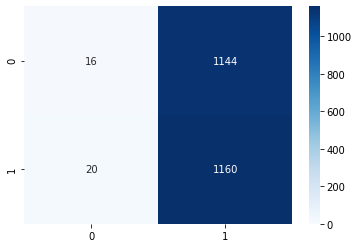

In [103]:
normalized_test_df = normalize_df(test_hc)
clusters_centroids = get_clusters_centroids(normalized_train_df, clusters_min_dist[-1])

# Armado de matriz de confusión (filas: valores reales; columnas: valores predictivos)
confusion_matrix = { 0: {}, 1: {} }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { 0: 0, 1: 0 }

for clase, cluster in zip(min_cluster_classes, clusters_min_dist[-1]):
    for _, test_row in normalized_test_df.iterrows():
        real_class = test_row[result_column]
        predicted_class = classify_with_centroids(clusters_centroids, min_cluster_classes, test_row[numeric_columns])
        confusion_matrix[real_class][predicted_class] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g', vmin=0)

### Utilizando la Máxima como medida de similitud entre grupos

In [104]:
clusters_max_dist = hierarchical_clustering(normalized_train_df, "max", 2, distance_matrix)
print(clusters_max_dist[-1])

[{17, 3, 20, 6, 22, 10}, {0, 1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 21}]


In [111]:
max_cluster_classes = classify_clusters(test_hc, clusters_max_dist[-1])
print(max_cluster_classes)

(0, 0)


<AxesSubplot:>

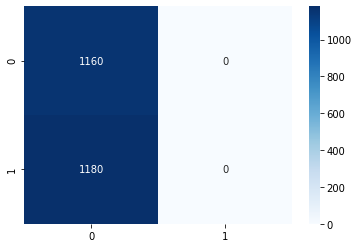

In [107]:
# Armado de matriz de confusión (filas: valores reales; columnas: valores predictivos)
confusion_matrix = { 0: {}, 1: {} }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { 0: 0, 1: 0 }

for clase, cluster in zip(max_cluster_classes, clusters_max_dist[-1]):
    for _, test_row in normalized_test_df.iterrows():
        real_class = test_row[result_column]
        predicted_class = classify_with_centroids(clusters_centroids, max_cluster_classes, test_row[numeric_columns])
        confusion_matrix[real_class][predicted_class] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g', vmin=0)

### Utilizando el Promedio como medida de similitud entre grupos

In [108]:
clusters_avg_dist = hierarchical_clustering(normalized_train_df, "avg", 2, distance_matrix)
print(clusters_avg_dist[-1])

[{0, 4, 5}, {1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}]


In [110]:
avg_cluster_classes = classify_clusters(test_hc, clusters_avg_dist[-1])
print(avg_cluster_classes)

(1, 0)


<AxesSubplot:>

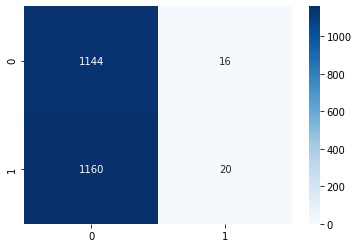

In [112]:
# Armado de matriz de confusión (filas: valores reales; columnas: valores predictivos)
confusion_matrix = { 0: {}, 1: {} }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { 0: 0, 1: 0 }

for clase, cluster in zip(avg_cluster_classes, clusters_avg_dist[-1]):
    for _, test_row in normalized_test_df.iterrows():
        real_class = test_row[result_column]
        predicted_class = classify_with_centroids(clusters_centroids, avg_cluster_classes, test_row[numeric_columns])
        confusion_matrix[real_class][predicted_class] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g', vmin=0)

### Utilizando el Centroide como medida de similitud entre grupos

In [113]:
clusters_ctr_dist = hierarchical_clustering(normalized_train_df, "ctr", 2, distance_matrix)
print(clusters_ctr_dist[-1])

[{4, 5}, {0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}]


In [115]:
ctr_cluster_classes = classify_clusters(test_hc, clusters_ctr_dist[-1])
print(ctr_cluster_classes)

(0, 0)


<AxesSubplot:>

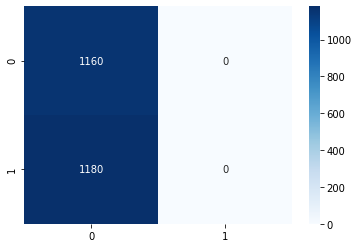

In [116]:
# Armado de matriz de confusión (filas: valores reales; columnas: valores predictivos)
confusion_matrix = { 0: {}, 1: {} }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { 0: 0, 1: 0 }

for clase, cluster in zip(ctr_cluster_classes, clusters_ctr_dist[-1]):
    for _, test_row in normalized_test_df.iterrows():
        real_class = test_row[result_column]
        predicted_class = classify_with_centroids(clusters_centroids, ctr_cluster_classes, test_row[numeric_columns])
        confusion_matrix[real_class][predicted_class] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g', vmin=0)

## K-medias

In [40]:
rng = np.random.default_rng()

# Update centroids based on points in the cluster
def update_centroids(data, classes):
    for clase in classes.values():
        if clase["changed"]:
            clase["centroid"] = np.array(list(map(lambda x: data.iloc[x], clase["indices"]))).mean(axis=0)
            clase["changed"] = False

def K_means(data, K=2):
    classes = {i: {"indices": set(), "centroid": np.zeros(len(numeric_columns)), "changed": True} for i in range(1, K+1)}
    
    # Set random clusters for every data point
    random_classes = rng.integers(1, K+1, size=len(data))
    for index, point_class in enumerate(random_classes):
        classes[point_class]["indices"].add(index)
    
    # Iterate until no changes are made in cluster
    while any(map(lambda x: x["changed"], classes.values())):
        update_centroids(data, classes)

        changes = []
        for clase, clase_value in classes.items():
            for point_index in clase_value["indices"]:
                point = data.iloc[point_index]
                
                # Get closest cluster based on distance to cluster centroids
                closest_class = (clase, np.linalg.norm(point - clase_value["centroid"]))
                for other_class, other_class_value in classes.items():
                    if clase == other_class:
                        continue

                    other_centroid = other_class_value["centroid"]
                    other_centroid_dist = np.linalg.norm(point - other_centroid)

                    if other_centroid_dist < closest_class[1]:
                        closest_class = (other_class, other_centroid_dist)

                if closest_class[0] != clase:
                    # Record belongs to another cluster, save for later update
                    changes.append({"old_cluster": clase, "new_cluster": closest_class[0], "point_index": point_index})

        # Update clusters
        for change in changes:
            old_cluster = classes[change["old_cluster"]]
            new_cluster = classes[change["new_cluster"]]
            old_cluster["indices"].remove(change["point_index"])
            new_cluster["indices"].add(change["point_index"])
            old_cluster["changed"] = new_cluster["changed"] = True
            
        print(f"Cluster changes processed: {len(changes)}")

    return classes

def classify_K_means(data, clusters):
    modes = []
    for cluster in clusters.values():
        cluster_rows = np.array(list(map(lambda x: data[result_column].iloc[x], cluster["indices"])))
        cluster_mode = stats.mode(cluster_rows)[0][0]
        modes.append(cluster_mode)
        
    return modes

def get_W(data, cluster):
    W = 0
    cluster_indices = list(cluster["indices"])
    for i in range(len(cluster_indices)):
        point_1 = data.iloc[cluster_indices[i]]
        for j in range(i+1, len(cluster_indices)):
            point_2 = data.iloc[cluster_indices[j]]
            W += sum(map(lambda x: (x[0] - x[1])**2, zip(point_1, point_2)))
    return W / len(cluster_indices)

def K_means_best(data, iterations=5, K=2):
    min_W_sum = None
    for i in range(iterations):
        sample, _ = train_test_split(data, test_size=0.3)
        K_means_clusters = K_means(sample, K)
        W_sum = 0
        
        # Calculate the sum of W of each cluster
        for current_K in range(1, K+1):
            W_sum += get_W(sample, K_means_clusters[current_K])
        
        # Get the best clusters based on minimum W sum
        if min_W_sum is None or W_sum < min_W_sum[1]:
            min_W_sum = (K_means_clusters, W_sum, sample)
            
        print(f"Finished iteration {i+1} - W sum: {W_sum}")
            
    return min_W_sum

def classify_K_means_best(data, sample, clusters):
    modes = []
    for cluster in clusters.values():
        # sample:
        # index | cad.dur   | age | ...
        # 1774  | 0.6       | 0.6 | ...
        # 3297  | 0.4       | 0.5 | ...
        #
        # data:
        # index | sex | cad.dur | ... | sigdz
        # 1774  | 1   | 0.6     | ... | 0
        # 3297  | 0.4 | 0.5    | ...  | 1
        #
        # Based on index in sample (1774), look for result column (sigdz) in entire data set - subsample does not have column sigdz and has less rows
        cluster_rows = np.array(list(map(lambda x: data[result_column].loc[sample.index[x]], cluster["indices"])))
        cluster_mode = stats.mode(cluster_rows)[0][0]
        modes.append(cluster_mode)
        
    return modes

In [41]:
# Use balanced dataset, without dividing into training and testing
complete_normalized_df = df.copy()
for column in numeric_columns:
    column_min = min(complete_normalized_df[column])
    column_max = max(complete_normalized_df[column])
    complete_normalized_df[column] = complete_normalized_df[column].apply(lambda x: (x - column_min) / (column_max - column_min))

complete_numeric_norm_df = complete_normalized_df[numeric_columns]

In [42]:
complete_normalized_df.head()

,sex,age,cad.dur,choleste,sigdz,tvdlm
3,1,0.630769,0.206731,0.345850,0,0.0
4,1,0.600000,0.016827,0.393281,0,0.0
11,0,0.276923,0.105769,0.369565,0,0.0
12,1,0.800000,0.024038,0.308300,0,0.0
20,1,0.538462,0.072115,0.335968,0,0.0


In [43]:
complete_normalized_df.iloc[3]

sex         1.000000
age         0.800000
cad.dur     0.024038
choleste    0.308300
sigdz       0.000000
tvdlm       0.000000
Name: 12, dtype: float64

In [44]:
K_means_clusters = K_means(complete_numeric_norm_df, 2)

Cluster changes processed: 1112
Cluster changes processed: 131
Cluster changes processed: 104
Cluster changes processed: 153
Cluster changes processed: 205
Cluster changes processed: 223
Cluster changes processed: 198
Cluster changes processed: 132
Cluster changes processed: 57
Cluster changes processed: 31
Cluster changes processed: 15
Cluster changes processed: 16
Cluster changes processed: 10
Cluster changes processed: 4
Cluster changes processed: 1
Cluster changes processed: 1
Cluster changes processed: 1
Cluster changes processed: 0


In [45]:
classify_K_means(complete_normalized_df, K_means_clusters)

[1, 0]

In [46]:
get_W(complete_numeric_norm_df, K_means_clusters[1])

48.97203274351613

In [47]:
get_W(complete_numeric_norm_df, K_means_clusters[2])

24.664287282277805

Run K-means algorithm multiple times and keep the data that gives the minimum W(C_k) sum

In [48]:
K_means_best_clusters, min_W_sum, K_means_best_sample = K_means_best(complete_numeric_norm_df, 5, 2)

Cluster changes processed: 791
Cluster changes processed: 100
Cluster changes processed: 34
Cluster changes processed: 27
Cluster changes processed: 21
Cluster changes processed: 12
Cluster changes processed: 17
Cluster changes processed: 9
Cluster changes processed: 6
Cluster changes processed: 3
Cluster changes processed: 4
Cluster changes processed: 2
Cluster changes processed: 2
Cluster changes processed: 0
Finished iteration 1 - W sum: 51.98848541740658
Cluster changes processed: 799
Cluster changes processed: 158
Cluster changes processed: 85
Cluster changes processed: 37
Cluster changes processed: 38
Cluster changes processed: 56
Cluster changes processed: 55
Cluster changes processed: 47
Cluster changes processed: 41
Cluster changes processed: 34
Cluster changes processed: 40
Cluster changes processed: 27
Cluster changes processed: 13
Cluster changes processed: 12
Cluster changes processed: 7
Cluster changes processed: 8
Cluster changes processed: 4
Cluster changes processed: 2

In [49]:
K_means_best_classes = classify_K_means_best(complete_normalized_df, K_means_best_sample, K_means_best_clusters)

In [50]:
K_means_best_classes

[1, 0]

<AxesSubplot:>

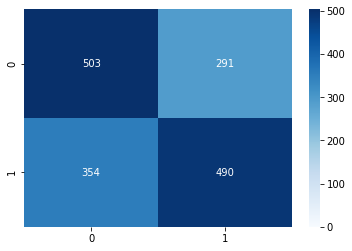

In [51]:
# Armado de matriz de confusión (filas: valores reales; columnas: valores predictivos)
confusion_matrix = { 0: {}, 1: {} }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { 0: 0, 1: 0 }

for clase, cluster in zip(K_means_best_classes, K_means_best_clusters.values()):
    for index in cluster["indices"]:
        real_class = complete_normalized_df[result_column].loc[K_means_best_sample.index[index]]
        confusion_matrix[real_class][clase] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g', vmin=0)

### Redes de Kohonen

In [52]:
import numpy as np

def update_R(epoch, max_epochs, initial_R):
    return (max_epochs - epoch) * initial_R / max_epochs

# Usamos la distancia euclidea como medida de similitud para saber cual es la neurona ganadora
def euclidean_distance(w, xp):
    return np.linalg.norm(w - xp)

# Actualizacion de los pesos para la neurona ganadora para el ejemplo de entrenamiento
def update_w_winning_neuron(w, n, xp):
    delta_w = n * (xp - w)
    return w + delta_w

# Actualizacion de pesos para una neurona que esta en el vecindario de la neurona ganadora
def update_w_neighbour(w, n, xp, d, R):
    V = math.exp(-2 * d / R)
    delta_w = V * n * (xp - w)
    return w + delta_w
    
def update_learning_factor(epoch, max_epochs):
    return 0.1 * (1 - (epoch / max_epochs))

def update_neighbours(matrix, coords, R, k, n, xp):
    for i in range(k):
        for j in range(k):
            dist = np.linalg.norm(np.array([i, j]) - np.array([coords[0], coords[1]]))
            if (dist <= R):
                V = math.exp(-2 * dist / R)
                delta_w = V * n * (xp - matrix[i][j])
                matrix[i][j] += delta_w
    
            
            
def get_winning_neuron(matrix, xp, k):
    min_dist = None
    min_coords = None
    for i in range(k):
        for j in range(k):
            dist = euclidean_distance(matrix[i][j], xp)
            if min_dist is None or dist < min_dist:
                min_dist = dist
                min_coords = (i, j)
    return min_coords

In [53]:
# Crear una matriz de [K x K] para la capa de salida
# en cada posicion i,j hay un vector w con n pesos (dim de la cantidad de atributos
# de un ejemplo del dataset)

def train_kohonen(data, k=20, max_epochs=500):
    R = k
    epoch = 0
    n = 0.1
    # Inicializar los pesos con ~ U(-1, 1)
    matrix = [[rng.uniform(1, -1, len(numeric_columns)) for x in range(k)] for y in range(k)]
    
    while epoch < max_epochs:
        
        for index, row in data.iterrows():
            xp = row.to_numpy()
            coords = get_winning_neuron(matrix, xp, k)
            winning_w = matrix[coords[0]][coords[1]]
            matrix[coords[0]][coords[1]] = update_w_winning_neuron(winning_w, n, xp)
            update_neighbours(matrix, coords, R, k, n, xp)
        
        epoch += 1
        R = update_R(epoch, max_epochs, k)
        n = update_learning_factor(epoch, max_epochs)
        print(epoch)
        
    return matrix

In [54]:
def create_count_matrix(data, matrix):
    k = len(matrix)
    count_matrix = [[[0, 0] for x in range(k)] for y in range(k)]
    for index, row in data.iterrows():
        xp = row[numeric_columns].to_numpy()
        coords = get_winning_neuron(matrix, xp, k)
        count_matrix[coords[0]][coords[1]][int(row[result_column])] += 1
        
    return count_matrix
    
    
def classify_kohonen(data, matrix):
    k = len(matrix)
    class_matrix = [[None for x in range(k)] for y in range(k)]
    count_matrix = create_count_matrix(data, matrix)
    for i in range(k):
        for j in range(k):
            if count_matrix[i][j][0] == 0 and count_matrix[i][j][1] == 0:
                class_matrix[i][j] = None
            elif count_matrix[i][j][0] >= count_matrix[i][j][1]:
                class_matrix[i][j] = 0
            else: 
                 class_matrix[i][j] = 1
    
    return class_matrix
            

In [55]:
ranged_df = df.copy()
for column in numeric_columns:
    mean = ranged_df[column].mean()
    std = ranged_df[column].std()
    ranged_df[column] = ranged_df[column].apply(lambda x: (x - mean) / std)

train_kohonen_df, test_kohonen_df = train_test_split(ranged_df, test_size=0.2)

kohonen_matrix = train_kohonen(train_kohonen_df[numeric_columns], k=4, max_epochs=500)

tagged_neurons = classify_kohonen(train_kohonen_df, kohonen_matrix)

print(tagged_neurons)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176


KeyboardInterrupt: 

<AxesSubplot:>

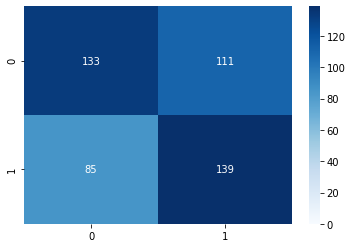

In [92]:
# Armado de matriz de confusión (filas: valores reales; columnas: valores predictivos)
confusion_matrix = { 0: {}, 1: {} }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { 0: 0, 1: 0 }

for index, row in test_kohonen_df.iterrows():
    
    real_class = row[result_column]
    coords = get_winning_neuron(kohonen_matrix, row[numeric_columns].to_numpy(), len(kohonen_matrix))
    predicted_class = tagged_neurons[coords[0]][coords[1]]
    confusion_matrix[real_class][predicted_class] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g', vmin=0)